<a href="https://colab.research.google.com/github/ShubhamML/Emotion-In-Text-Classifier-App-/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End to End NLP project
+ Emotion detection in text
+ Text classifier

In [ ]:
!pip install neattext

In [ ]:
# importing libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# for text preprocessing
import neattext.functions as nfx

# Ml libraries
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import  SVC

# Transformers
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [ ]:
# Loading the dataset
df = pd.read_csv('emotion_dataset_raw.csv')
df.head()

,Emotion,Text
0,neutral,Why ?
1,joy,Sage Act upgrade on my to do list for tommorow.
2,sadness,ON THE WAY TO MY HOMEGIRL BABY FUNERAL!!! MAN ...
3,joy,Such an eye ! The true hazel eye-and so brill...
4,joy,@Iluvmiasantos ugh babe.. hugggzzz for u .! b...


In [ ]:
df['Emotion'].value_counts()

joy         11045
sadness      6722
fear         5410
anger        4297
surprise     4062
neutral      2254
disgust       856
shame         146
Name: Emotion, dtype: int64

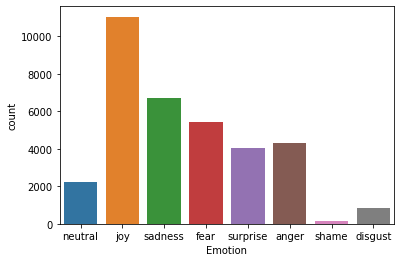

In [ ]:
#visualizing the data
sns.countplot(x='Emotion', data=df)

In [ ]:
# data cleaning
df['Clean_Text'] = df['Text'].apply(nfx.remove_userhandles)
#stopwords
df['Clean_Text'] = df['Clean_Text'].apply(nfx.remove_stopwords)

df

,Emotion,Text,Clean_Text
0,neutral,Why ?,?
1,joy,Sage Act upgrade on my to do list for tommorow.,Sage Act upgrade list tommorow.
2,sadness,ON THE WAY TO MY HOMEGIRL BABY FUNERAL!!! MAN ...,WAY HOMEGIRL BABY FUNERAL!!! MAN HATE FUNERALS...
3,joy,Such an eye ! The true hazel eye-and so brill...,eye ! true hazel eye-and brilliant ! Regular f...
4,joy,@Iluvmiasantos ugh babe.. hugggzzz for u .! b...,ugh babe.. hugggzzz u .! babe naamazed nga ako...
...,...,...,...
34787,surprise,@MichelGW have you gift! Hope you like it! It'...,gift! Hope like it! hand wear ! It'll warm! Lol
34788,joy,The world didnt give it to me..so the world MO...,world didnt me..so world DEFINITELY cnt away!!!
34789,anger,A man robbed me today .,man robbed today .
34790,fear,"Youu call it JEALOUSY, I call it of #Losing YO...","Youu JEALOUSY, #Losing YOU..."


In [ ]:
# Feature Engineering
X=df['Clean_Text']
y=df['Emotion']

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

In [ ]:
# Build pipeline
from sklearn.pipeline import Pipeline
# Logistic Regression pipeline
pipe_lr=Pipeline(steps=[('cv', CountVectorizer()),('nb',LogisticRegression())])
pipe_lr.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Pipeline(steps=[('cv', CountVectorizer()), ('nb', LogisticRegression())])

In [ ]:
pipe_lr.score(X_test,y_test)

0.6241664750517361

In [ ]:
# Making prediction
pred1="This made me happy"
pipe_lr.predict([pred1])

array(['joy'], dtype=object)

In [ ]:
# Saving the model and pipeline
import joblib
pipeline_file=open("emotion_classifier_pipe_lr.pkl","wb")
joblib.dump(pipe_lr,pipeline_file)
pipeline_file.close()

In [ ]:
!pip install streamlit

In [ ]:
%%writefile app.py
# Core Pkgs
import streamlit as st 
import altair as alt
import plotly.express as px 

# EDA Pkgs
import pandas as pd 
import numpy as np 
from datetime import datetime

# Utils
import joblib 
pipe_lr = joblib.load(open("emotion_classifier_pipe_lr.pkl","rb"))


# Track Utils
from track_utils import create_page_visited_table,add_page_visited_details,view_all_page_visited_details,add_prediction_details,view_all_prediction_details,create_emotionclf_table

# Fxn
def predict_emotions(docx):
	results = pipe_lr.predict([docx])
	return results[0]

def get_prediction_proba(docx):
	results = pipe_lr.predict_proba([docx])
	return results

emotions_emoji_dict = {"anger":"😠","disgust":"🤮", "fear":"😨😱", "happy":"🤗", "joy":"😂", "neutral":"😐", "sad":"😔", "sadness":"😔", "shame":"😳", "surprise":"😮"}


# Main Application
def main():
	st.title("Emotion Classifier App")
	menu = ["Home","Monitor","About"]
	choice = st.sidebar.selectbox("Menu",menu)
	create_page_visited_table()
	create_emotionclf_table()
	if choice == "Home":
		add_page_visited_details("Home",datetime.now())
		st.subheader("Home-Emotion In Text")

		with st.form(key='emotion_clf_form'):
			raw_text = st.text_area("Type Here")
			submit_text = st.form_submit_button(label='Submit')

		if submit_text:
			col1,col2  = st.beta_columns(2)

			# Apply Fxn Here
			prediction = predict_emotions(raw_text)
			probability = get_prediction_proba(raw_text)
			
			add_prediction_details(raw_text,prediction,np.max(probability),datetime.now())

			with col1:
				st.success("Original Text")
				st.write(raw_text)

				st.success("Prediction")
				emoji_icon = emotions_emoji_dict[prediction]
				st.write("{}:{}".format(prediction,emoji_icon))
				st.write("Confidence:{}".format(np.max(probability)))



			with col2:
				st.success("Prediction Probability")
				# st.write(probability)
				proba_df = pd.DataFrame(probability,columns=pipe_lr.classes_)
				# st.write(proba_df.T)
				proba_df_clean = proba_df.T.reset_index()
				proba_df_clean.columns = ["emotions","probability"]

				fig = alt.Chart(proba_df_clean).mark_bar().encode(x='emotions',y='probability',color='emotions')
				st.altair_chart(fig,use_container_width=True)



	elif choice == "Monitor":
		add_page_visited_details("Monitor",datetime.now())
		st.subheader("Monitor App")

		with st.beta_expander("Page Metrics"):
			page_visited_details = pd.DataFrame(view_all_page_visited_details(),columns=['Pagename','Time_of_Visit'])
			st.dataframe(page_visited_details)	

			pg_count = page_visited_details['Pagename'].value_counts().rename_axis('Pagename').reset_index(name='Counts')
			c = alt.Chart(pg_count).mark_bar().encode(x='Pagename',y='Counts',color='Pagename')
			st.altair_chart(c,use_container_width=True)	

			p = px.pie(pg_count,values='Counts',names='Pagename')
			st.plotly_chart(p,use_container_width=True)

		with st.beta_expander('Emotion Classifier Metrics'):
			df_emotions = pd.DataFrame(view_all_prediction_details(),columns=['Rawtext','Prediction','Probability','Time_of_Visit'])
			st.dataframe(df_emotions)

			prediction_count = df_emotions['Prediction'].value_counts().rename_axis('Prediction').reset_index(name='Counts')
			pc = alt.Chart(prediction_count).mark_bar().encode(x='Prediction',y='Counts',color='Prediction')
			st.altair_chart(pc,use_container_width=True)	



	else:
		st.subheader("About")
		add_page_visited_details("About",datetime.now())





if __name__ == '__main__':
	main()

Overwriting app.py


In [ ]:
!nohup streamlit run app.py & npx localtunnel --port 8501

url=ngrok.connect(port='8501')
url

nohup: appending output to 'nohup.out'
npx: installed 22 in 2.435s
your url is: https://rare-fly-8.loca.lt
